# Calibration - broken

Kevin Walchko

---

I made some changes and it broke!!!

We can use `apriltags` to calibrate a camera. 

`cv2.aruco` can detect these tags:

```python
cv2.aruco.DICT_APRILTAG_16H5 = 17
cv2.aruco.DICT_APRILTAG_25h9 = 18
cv2.aruco.DICT_APRILTAG_36H10 = 19
cv2.aruco.DICT_APRILTAG_36H11 = 20
```

In [2]:
# reload library
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
import moms_apriltag as apt # generate a target board
import imageio # save the target board to a file for printing
from pathlib import Path
from opencv_camera import __version__ as ocv_version
from opencv_camera import StereoCalibration
from opencv_camera import StereoCamera
from opencv_camera.apriltag.apriltag_marker import Tag
from opencv_camera import ApriltagMarker, ApriltagTargetFinder
from opencv_camera.apriltag.calibrate import ApriltagStereoCalibration
from opencv_camera import coverage
from opencv_camera import visualizeDistortion
from opencv_camera import mosaic
# from opencv_camera import isBlurry
print("OpenCV Camera:", ocv_version)

# from math import asin, atan2,pi
from colorama import Fore

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

OpenCV Camera: 0.11.0


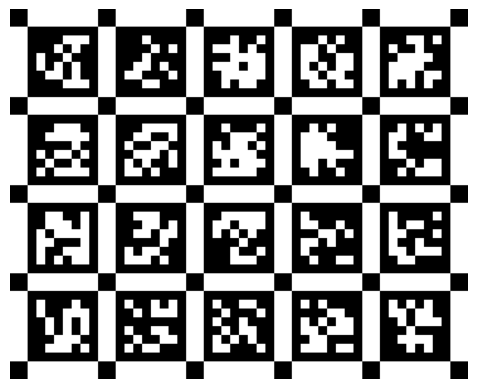

In [4]:
family = "tag36h10"
shape = (4,5)
filename = "apriltag_target.png"
size = 50 # scale image, otherwise each marker is 8x8 pixels

tgt = apt.board(shape, family, size)
imageio.imwrite(filename, tgt)

plt.imshow(tgt, cmap="gray")
plt.axis("off");

Total tags found 20, tag ids:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


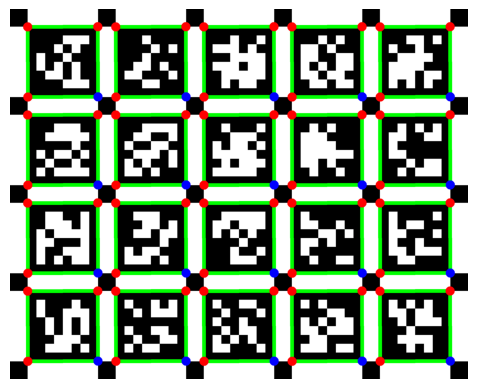

In [5]:
def find(img):
    # ok, img = cv2.threshold(img,150,255,cv2.THRESH_BINARY)
    # img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
    
    corners, ids, rejectedImgPts = aruco.detectMarkers(
        img,
        aruco.Dictionary_get(aruco.DICT_APRILTAG_36h10), 
        parameters=aruco.DetectorParameters_create(),
    )
    
    # 36h10 is 8x8
    # min pix/bit sampling 5
    # need each side of tag to 8*5 = 40
    # min_pix = 40
    # for i,c in zip(ids, corners[0]):
    #     # print(c)
    #     dist = np.sqrt((c[0,0] - c[1,0])**2 + (c[0,1] - c[1,1])**2)
    #     if dist < min_pix:
    #         print(f"Bad image {i}: {c}")

    # turn the detections into a list of Tags and draw them on the image
    tags = ApriltagMarker.tagArray(ids, corners)
    at = ApriltagMarker()
    img = at.draw(img, tags)

    ids = ids.flatten()
    ids = sorted(ids)
    print(f"Total tags found {len(ids)}, tag ids:")
    for i in ids:
        print(i, end=" ")
    print("")
    return img


img = find(tgt)
plt.imshow(img)
plt.axis("off");

In [6]:
path = Path("cal_imgs")
files = list(path.rglob("*.png"))
func = lambda f: int(f.stem) # 
files = sorted(files, key=func)

imgs = []
for f in files:
    f = str(f)
    imgs.append(cv2.imread(f, 0))
print(f"{len(imgs)} images found")

44 images found


In [7]:
imgsL, imgsR = [], []
h,w = imgs[0].shape

for im in imgs:
    l = im[:, :w//2]
    r = im[:, w//2:]
    
    # thres = 300
    # bl, val = isblurry(l, thres)
    # br, val = isblurry(r, thres)
    # if bl or br:
    #     continue
    
    imgsL.append(l)
    imgsR.append(r)
    
# print(f"left: {imgsL[0].shape} right: {imgsR[0].shape}")
# print(f"Found {len(imgsL)} good images out of {len(imgs)} images")
# plt.imshow(imgsR[0], cmap="gray")
# plt.axis("off");

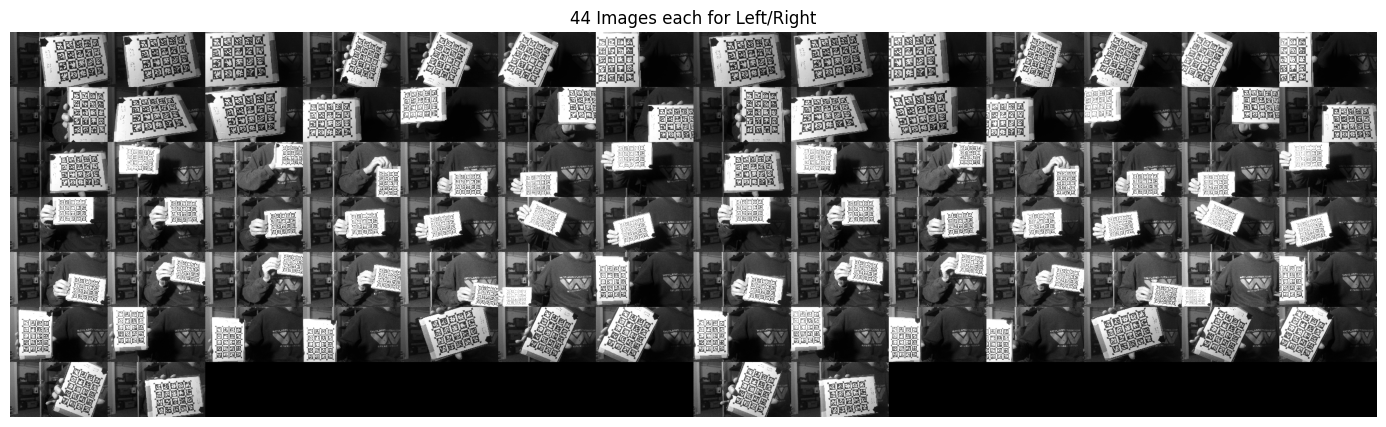

In [79]:
l = mosaic(imgsL)
r = mosaic(imgsR)
plt.figure(figsize=(20,5))
plt.imshow(np.hstack((l,r)),cmap="gray")
plt.title(f"{len(imgsL)} Images each for Left/Right")
plt.axis("off");

In [9]:
# for i, (l, r) in enumerate(zip(imgsL, imgsR)):
#     thres = 100
#     blur, val = isblurry(l, thres)
#     c = Fore.RED if blur is True else ""
#     print(f"{c}{i:3}: left: {blur},{val}{Fore.RESET}", end="   ")
#     blur, val = isblurry(r, thres)
#     c = Fore.RED if blur is True else ""
#     print(f"{c}right: {blur},{val}{Fore.RESET}")

Total tags found 19, tag ids:
0 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 
Total tags found 19, tag ids:
0 1 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


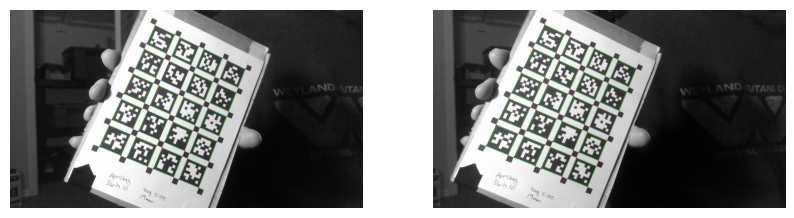

In [10]:
plt.figure(figsize=(10,5))
num = 4
plt.subplot(121); plt.imshow(find(imgsL[num]), cmap="gray");plt.axis("off");
plt.subplot(122); plt.imshow(find(imgsR[num]), cmap="gray");plt.axis("off");

## Calibrate Stereo Camera using Apriltags

In [11]:
board = ApriltagTargetFinder(size=(4,5), scale=0.019, family=aruco.DICT_APRILTAG_36h10)
objpts = board.objectPoints
print(objpts[0])

# [[0.005 0.005 0.   ]
#  [0.024 0.005 0.   ]
#  [0.024 0.024 0.   ]
#  [0.005 0.024 0.   ]]

[[0.024 0.024 0.   ]
 [0.005 0.024 0.   ]
 [0.005 0.005 0.   ]
 [0.024 0.005 0.   ]]


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


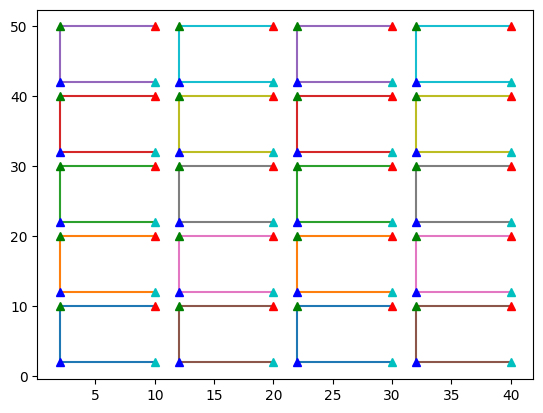

In [20]:
# this is upside down since
# (0,0) on an image is top left corner
# but here it is bottom left corner
#
# aruco pt order in image:
# 3     4
# +-----+
# |     |
# |     |
# +-----+
# 2     1
#
for k,v in objpts.items():
    v = 8/0.019 * v
    v = v.astype(int)
    plt.plot(v[:,0],v[:,1])
    plt.plot(v[0,0],v[0,1],"r^") # 1
    plt.plot(v[1,0],v[1,1],"g^") # 2
    plt.plot(v[2,0],v[2,1],"b^") # 3
    plt.plot(v[3,0],v[3,1],"c^") # 4

print(objpts.keys())

In [39]:
from opencv_camera.apriltag.calibrate import MarkerCameraCalibration

board = ApriltagTargetFinder(size=(4,5), scale=0.019, family=aruco.DICT_APRILTAG_36h10)
# cal = ApriltagStereoCalibration()
cc = MarkerCameraCalibration()

a,b,c = cc.findPoints(imgsL, board)
print(a.shape, len(b), len(c))
print(b[0].shape, c[0].shape)

(17,) 44 44
(40, 2) (40, 3)


In [95]:
# board = ApriltagTargetFinder(size=(4,5), scale=0.019, family=aruco.DICT_APRILTAG_36h10)
# should find 573 markers in BOTH images
# cal = ApriltagStereoCalibration()
ok, cameraModel = cal.calibrate(imgsL, imgsR, board)

-------
[[646.82  535.148]
 [751.144 518.008]
 [766.401 625.966]
 [661.748 645.253]]
[[0.024 0.119 0.   ]
 [0.005 0.119 0.   ]
 [0.005 0.1   0.   ]
 [0.024 0.1   0.   ]]
-------
[[776.255 513.749]
 [875.485 497.759]
 [891.476 602.953]
 [791.978 621.477]]
[[0.024 0.095 0.   ]
 [0.005 0.095 0.   ]
 [0.005 0.076 0.   ]
 [0.024 0.076 0.   ]]
-------
[[879.826 363.775]
 [973.193 350.831]
 [989.364 452.729]
 [895.648 467.81 ]]
[[0.047 0.071 0.   ]
 [0.029 0.071 0.   ]
 [0.029 0.052 0.   ]
 [0.047 0.052 0.   ]]
-------
[[ 996.068  347.955]
 [1084.219  335.763]
 [1100.377  434.769]
 [1012.221  449.146]]
[[0.047 0.047 0.   ]
 [0.029 0.047 0.   ]
 [0.029 0.029 0.   ]
 [0.047 0.029 0.   ]]
-------
[[860.295 236.32 ]
 [953.491 226.025]
 [968.958 325.885]
 [875.475 338.279]]
[[0.071 0.071 0.   ]
 [0.052 0.071 0.   ]
 [0.052 0.052 0.   ]
 [0.071 0.052 0.   ]]
-------
[[ 976.309  223.385]
 [1064.228  214.188]
 [1080.272  311.325]
 [ 992.132  322.831]]
[[0.071 0.047 0.   ]
 [0.052 0.047 0.   ]
 [0.052

In [80]:
cm = cameraModel # shorten variable name
sc = StereoCamera(
    cm["K1"],cm["d1"],
    cm["K2"],cm["d2"],
    cm["R"],cm["T"],
    cm["F"],
    cm["E"]
)

print(imgsL[0].shape)

h,w = imgsL[0].shape[:2]
f = max(h,w)*0.8  # focal length is a function of image size in pixels
K = np.array([
    [f,0,w//2],
    [0,f,h//2],
    [0,0,1]
])

print("Guess")
print(K)

print(sc)

(720, 1280)
Guess
[[1024.    0.  640.]
 [   0. 1024.  360.]
 [   0.    0.    1.]]
Camera 1 --------------------------
  focalLength(x,y): 5180.5 5052.3 px 
  principlePoint(x,y): 358.0 348.1 px
  distortionCoeffs: [[  -12.158   378.866     0.136     0.265 -5851.151]]
Camera 2 --------------------------
  focalLength(x,y): 4718.4 4952.1 px 
  principlePoint(x,y): 1040.9 617.6 px
  distortionCoeffs: [[   -8.061   141.505    -0.067    -0.428 -1598.99 ]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [[-0.03]
 [ 0.  ]
 [ 0.  ]]
  Rotation between Left/Right Camera:
    [[ 0.991 -0.004 -0.133]
     [-0.003  0.999 -0.053]
     [ 0.133  0.053  0.99 ]]
  Essential Matrix:
    [[ 0.    -0.     0.   ]
     [ 0.004  0.002  0.03 ]
     [-0.    -0.03   0.002]]
  Fundatmental Matrix:
    [[-0.     0.    -0.005]
     [-0.    -0.    -0.526]
     [ 0.012  0.531  1.   ]]



Max points in this image set: 3520


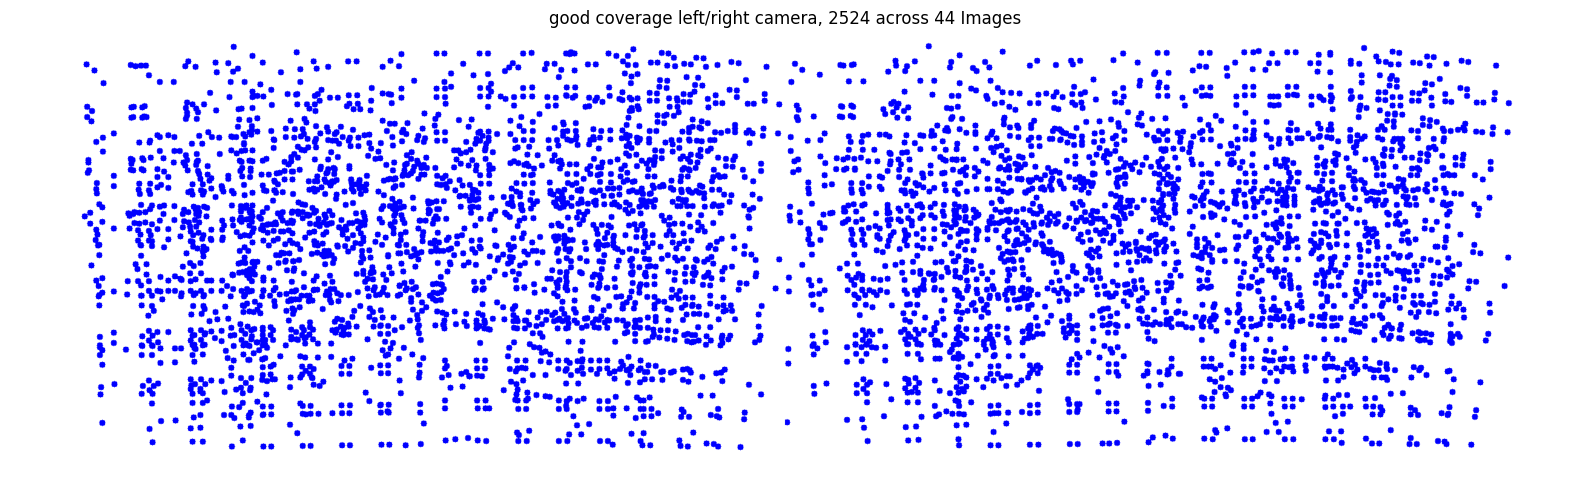

In [77]:
# Looking at the mosaic at the top, looks like there was
# good coverage, not sure what happened???

# draw image points mapped across camera focal plane
imgpoints_l = cameraModel["imgpointsL"]
imgpoints_r = cameraModel["imgpointsR"]

plt.figure(figsize=(20,10))
l, num = coverage(imgsL[0].shape[:2], np.vstack(imgpoints_l))
r, _ = coverage(imgsR[0].shape[:2], np.vstack(imgpoints_r))
plt.imshow(np.hstack((l,r)));
plt.title(f"good coverage left/right camera, {num} across {len(imgpoints_l)} Images")
plt.axis("off");

print(f"Max points in this image set: {4*5*4*44}")

# Scratch Work

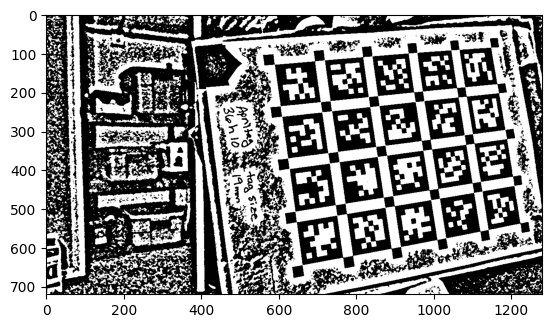

In [173]:
num = 0
# ok, img = cv2.threshold(imgsL[num],150,255,cv2.THRESH_BINARY)
img = cv2.adaptiveThreshold(imgsL[num],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,0)
plt.imshow(img,cmap="gray")

In [30]:
np.eye(3,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

NameError: name 'imgpoints_l' is not defined

In [68]:
a=np.arange(10)
b=range(10)

c = {m:n for m,n in zip(a,b)}
print(c)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [86]:
136/16

8.5

In [116]:
# a=np.array([[i,i,i,i] for i in range(40)])
# a=a.reshape((-1,4,4))

# print(a)
# b=np.arange(10)

# dict(zip(b,a))

## calculating tag size

If interested in pixels/bit bit on images, could look at this to determine if you can read the tag.

However, if already have image corners, then already read tag ... is this useful?

In [127]:
a=2*np.array([
    [1,1],
    [0,1],
    [0,0],
    [1,0]
])

# a = np.rot90(a)

print(a)

[[2 2]
 [0 2]
 [0 0]
 [2 0]]


In [128]:
print(np.sum(np.subtract(a[0],a[1])**2))
print(np.sum(np.subtract(a[1],a[2])**2))
print(np.sum(np.subtract(a[2],a[3])**2))
print(np.sum(np.subtract(a[3],a[0])**2))

4
4
4
4


In [131]:
a = np.array([[ 502.,  332.],
        [1078.,  322.],
        [1068.,  904.],
        [ 513.,  905.]])
print(a)
print(np.sqrt(np.sum(np.subtract(a[0],a[1])**2)))
print(np.sqrt(np.sum(np.subtract(a[1],a[2])**2)))
print(np.sqrt(np.sum(np.subtract(a[2],a[3])**2)))
print(np.sqrt(np.sum(np.subtract(a[3],a[0])**2)))

[[ 502.  332.]
 [1078.  322.]
 [1068.  904.]
 [ 513.  905.]]
576.086799015565
582.0859043131005
555.0009009001697
573.1055749161754


In [40]:
np.array([1,2,3]).shape

(3,)